<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/dave-updates/code/dave_naive_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import sys
# !{sys.executable} -m pip install pyspark==3.1.2 -q
# !{sys.executable} -m pip install spark-nlp==4.2.0 -q

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('drive/MyDrive/696/text_difficulty_features.csv',sep='\t')
df.head(5)

,original_text,lemmatized_text,d_chall_score,aoa_mean,aoa_min,aoa_max,conc_rating_mean,conc_rating_min,conc_rating_max,num_lemmas,label
0,There is manuscript evidence that Austen conti...,There be manuscript evidence that Austen conti...,8.533221,5.809310,3.57,12.12,2.495517,1.33,4.57,38.0,1
1,"In a remarkable comparative analysis , Mandaea...","In a remarkable comparative analysis , Mandaea...",12.320171,7.402308,2.89,11.94,2.334286,1.46,4.93,21.0,1
2,"Before Persephone was released to Hermes , who...","Before Persephone be release to Hermes , who h...",5.931500,5.231351,2.78,11.17,2.556486,1.43,4.86,40.0,1
3,Cogeneration plants are commonly found in dist...,Cogeneration plant be commonly find in distric...,7.015012,6.742000,3.56,11.53,3.369655,1.52,4.93,32.0,1
4,Geneva is the second-most-populous city in Swi...,Geneva be the second-most-populous city in Swi...,7.550745,5.455000,3.69,12.62,2.399333,1.43,4.79,22.0,1


In [4]:
df.dtypes

original_text        object
lemmatized_text      object
d_chall_score       float64
aoa_mean            float64
aoa_min             float64
aoa_max             float64
conc_rating_mean    float64
conc_rating_min     float64
conc_rating_max     float64
num_lemmas          float64
label                 int64
dtype: object

In [5]:
# Extract only the columns we'll use for the classifier
df = df[df.columns[:]]

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X = df[df.columns[:-1]]
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=.1,
                                                    stratify=y,
                                                    random_state=99)

In [19]:
#  Training_Set = pd.concat([X_train, pd.DataFrame(y_train)], axis=1)
#  Testing_Set = pd.concat([X_test, pd.DataFrame(y_test)], axis=1)
#  Testing_Set.to_csv('drive/Shareddrives/Milestone 2/Testing_set.csv', sep='\t', index=False)
# #  Training_Set.to_csv('drive/Shareddrives/Milestone 2/Training_set.csv', sep='\t', index=False)

X_train = pd.read_csv('drive/Shareddrives/Milestone 2/Training_set.csv', sep='\t')
X_train.set_index('Unnamed: 0', inplace=True)
X_train.index.names = ['index']




In [72]:
X_train.shape

(355652, 10)

In [20]:
X_train.head()

,lemmatized_text,d_chall_score,aoa_mean,aoa_min,aoa_max,conc_rating_mean,conc_rating_min,conc_rating_max,num_lemmas,label
index,,,,,,,,,,
91224,For instance the number of k-permutations of n...,4.542700,5.140000,3.94,9.57,2.577500,1.43,4.55,12.0,1
117728,Singer and bass player Roger Waters gradually ...,7.556000,5.835000,3.69,11.11,2.637727,1.33,4.62,25.0,1
316017,Other page 2005 Macquarie Fields riot 2005 Cro...,10.714000,6.456250,3.89,10.00,3.042500,1.43,4.90,25.0,0
7423,Saint-Denis be founded by Ã tienne RÃ gnault i...,8.887000,5.613637,3.69,9.39,2.545454,1.43,4.96,20.0,1
201052,Pougny be a commune in the Ain department in e...,7.722873,6.232500,2.89,12.05,2.505000,1.43,3.30,11.0,1


In [21]:
metrics_df = {"model":[],
              "accuracy": [],
              "precision": [],
              "recall": [],
              "aucprc":[],
              "aucroc": []}

In [22]:
from sklearn. metrics import precision_score, recall_score, precision_recall_curve, roc_auc_score

In [23]:
from sklearn.metrics._plot.precision_recall_curve import plot_precision_recall_curve


In [24]:
def compute_metrics(model,model_name, X_test_vec, y_test):
    # extract the model's hyperparameters and make that part of the identifier for the model 

    y_pred = model.predict(X_test_vec)
    acc = model.score(X_test_vec, y_test)
    recall = recall_score(y_test,y_pred)
    precision = precision_score(y_test, y_pred)
    y_proba = model.predict_proba(X_test_vec)[:,1]
    prc = precision_recall_curve(y_test, y_proba)
    roc = roc_auc = roc_auc_score(y_test, y_proba)
    
    metrics_df['model'].append(model_name)
    metrics_df['accuracy'].append(acc)
    metrics_df['recall'].append(recall)
    metrics_df['precision'].append(precision)
    metrics_df['aucprc'].append(prc)
    metrics_df['aucroc'].append(roc)








In [25]:
# NaiveBayes Classifier with Tfidf Vectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

In [26]:
tf_vec = TfidfVectorizer(min_df = 20,
                         stop_words='english',
                         ngram_range=(1, 3))

In [27]:
X_train_vec = tf_vec.fit_transform(X_train['lemmatized_text'])

In [28]:
from sklearn.model_selection import GridSearchCV


In [29]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1,5,10,50, 100]}
grid_mnb_rmse = GridSearchCV(MultinomialNB(), param_grid=param_grid, scoring='neg_root_mean_squared_error')
grid_mnb_rmse.fit(X_train_vec,y_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 5, 10, 50, 100]},
             scoring='neg_root_mean_squared_error')

In [30]:
grid_mnb_rmse.cv_results_

{'mean_fit_time': array([0.11542873, 0.11243043, 0.11041946, 0.11563869, 0.11197958,
        0.11251965, 0.11066856, 0.10885715]),
 'std_fit_time': array([0.00351629, 0.00452007, 0.00338808, 0.00552754, 0.00321628,
        0.00757919, 0.0039514 , 0.00062777]),
 'mean_score_time': array([0.01148744, 0.00915198, 0.01023126, 0.00896487, 0.01046214,
        0.00928936, 0.00882764, 0.00991664]),
 'std_score_time': array([2.02283770e-03, 5.96188326e-04, 1.67228171e-03, 7.63277039e-05,
        2.08248910e-03, 4.18535911e-04, 1.14221004e-04, 2.29967208e-03]),
 'param_alpha': masked_array(data=[0.001, 0.01, 0.1, 1, 5, 10, 50, 100],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.001},
  {'alpha': 0.01},
  {'alpha': 0.1},
  {'alpha': 1},
  {'alpha': 5},
  {'alpha': 10},
  {'alpha': 50},
  {'alpha': 100}],
 'split0_test_score': array([-0.61250873, -0.6124743 , -0.61216435, -0.61048558, -0.6083

In [31]:
# Looks like alpha of 5 is the best parameter based on rmse
grid_mnb_rmse.best_params_

{'alpha': 5}

In [33]:
mnb = MultinomialNB(alpha=5).fit(X_train_vec, y_train)
model_name = 'Tf-idf NB alpha 5'
X_test_vec = tf_vec.transform(X_test['lemmatized_text'])
compute_metrics(mnb,model_name,X_test_vec, y_test)



In [34]:
metrics_df

{'model': ['Tf-idf NB alpha 5'],
 'accuracy': [0.6302350886960042],
 'precision': [0.6189553564220553],
 'recall': [0.7477811372281283],
 'aucprc': [(array([0.53178081, 0.53176867, 0.53178246, ..., 1.        , 1.        ,
          1.        ]),
   array([1.        , 0.99995123, 0.99995123, ..., 0.00214571, 0.00204818,
          0.        ]),
   array([0.13515109, 0.13575168, 0.13589074, ..., 0.99989217, 0.99989711,
          0.99992042]))],
 'aucroc': [0.6960772870858367]}

In [ ]:
# Mads Features

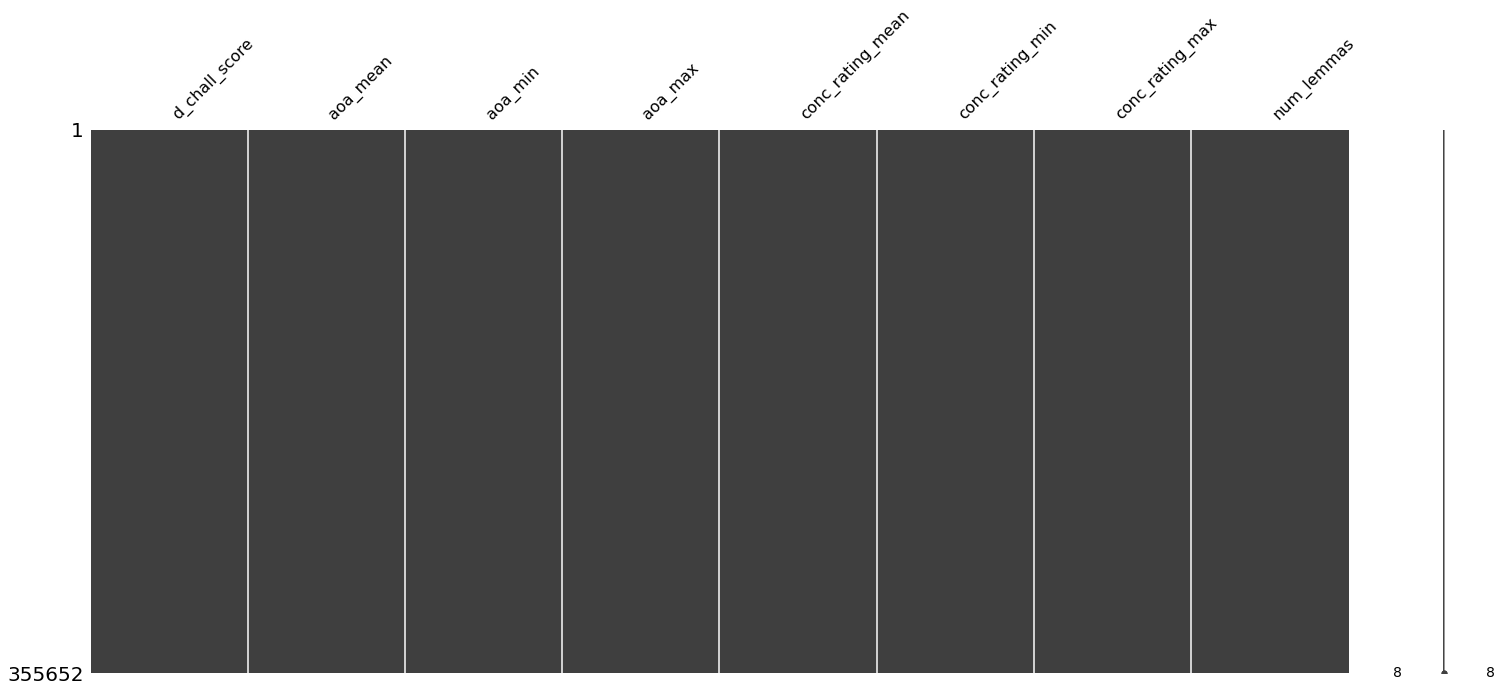

In [140]:
X_train_mads_features = X_train.iloc[:,1:9]
X_train_mads_features.fillna(0,inplace=True)
msno.matrix(mads_features_raw)


In [141]:
X_train_mads_features.describe()

,d_chall_score,aoa_mean,aoa_min,aoa_max,conc_rating_mean,conc_rating_min,conc_rating_max,num_lemmas
count,355652.000000,355652.000000,355652.000000,355652.000000,355652.000000,355652.000000,355652.000000,355652.000000
mean,7.556820,5.754486,3.395488,10.419735,2.653873,1.461432,4.427434,19.759959
std,2.687109,1.005083,0.823235,2.597162,0.422728,0.344298,0.684466,10.539020
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.729000,5.227500,2.890000,8.780000,2.443200,1.430000,4.170000,12.000000
50%,7.461543,5.676957,3.280000,10.500000,2.636000,1.430000,4.690000,18.000000
75%,9.158327,6.205271,3.690000,12.110000,2.860588,1.430000,4.880000,25.000000
max,18.716400,18.330000,18.330000,25.000000,5.000000,5.000000,5.000000,76.000000


In [142]:
param_grid = {'alpha': [0.001, 0.01,0.1,.5,1,2,3,4,5,10,25,50,100,500]}
grid_mnb_mads_rmse = GridSearchCV(MultinomialNB(), param_grid=param_grid, scoring='neg_root_mean_squared_error')
grid_mnb_mads_rmse.fit(X_train_mads_features,y_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.5, 1, 2, 3, 4, 5, 10, 25,
                                   50, 100, 500]},
             scoring='neg_root_mean_squared_error')

In [143]:
grid_mnb_mads_rmse.best_estimator_

MultinomialNB(alpha=100)

(281, 8)


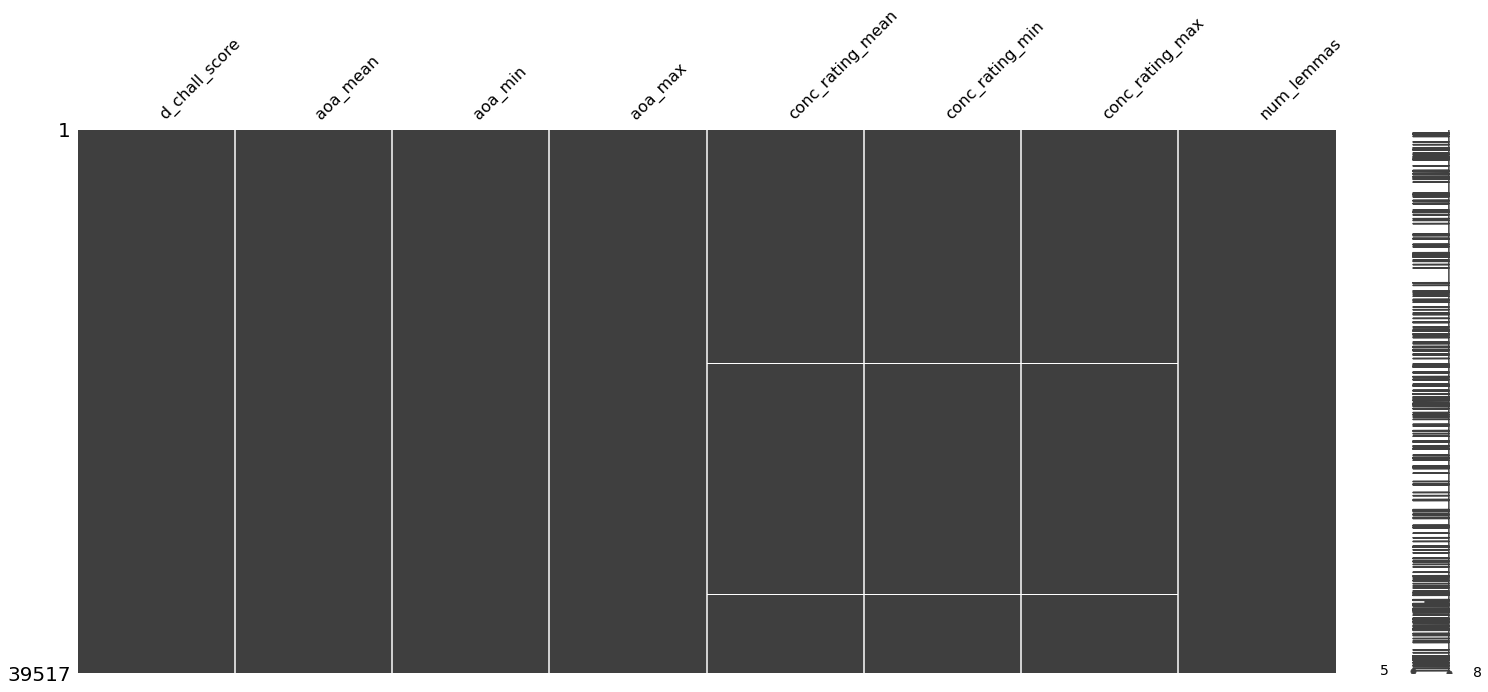

In [155]:
X_test_mads_features = X_test.iloc[:,2:10]
msno.matrix(X_test_mads_features)
print(X_test_mads_features[X_test_mads_features['conc_rating_mean'].isna()].shape)


In [156]:
X_test_mads_features.fillna(0,inplace=True)

In [157]:
mnb = MultinomialNB(alpha=100).fit(X_train_mads_features, y_train)
model_name = 'MADS NB alpha 100'
compute_metrics(mnb,model_name,X_test_mads_features, y_test)

In [22]:
# tfidf + Mads features

In [23]:
X_train_other = X_train[X_train.columns[1:]]

In [158]:
import scipy
from scipy.sparse import hstack
import numpy as np

In [159]:
# Create a sparse matrix from the MADS features
X_sparse = scipy.sparse.coo_matrix(X_train_mads_features)

# Join both the tfidf training matrix with the sparse MADS features
X_train_all = scipy.sparse.hstack((X_train_vec, X_sparse)).tocsr()




In [160]:
X_train_all[:5, :1000]


# toarray(X_train_all[0, :100])

<5x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [161]:
grid_mnb_all_rmse = GridSearchCV(MultinomialNB(), param_grid=param_grid, scoring='neg_root_mean_squared_error')
grid_mnb_all_rmse.fit(X_train_all,y_train)



GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.5, 1, 2, 3, 4, 5, 10, 25,
                                   50, 100, 500]},
             scoring='neg_root_mean_squared_error')

In [162]:
grid_mnb_all_rmse.best_estimator_

MultinomialNB(alpha=0.001)

In [163]:
# Update the test data: convert mads features to sparse, create
# one matrix for both the tfidf vec and mads features

X_test_sparse = scipy.sparse.coo_matrix(X_test_mads_features)

X_test_all = scipy.sparse.hstack((X_test_vec,
                                  X_test_sparse))

In [164]:
# Run model based on best parameters from gridsearch
mnb = MultinomialNB(alpha=.001).fit(X_train_all, y_train)
model_name = 'Tf-idf NB alpha .001'

# compute metrics from the test split data
compute_metrics(mnb,model_name,X_test_all, y_test)

In [35]:
# Sentence Embeddings

In [81]:
from numpy import loadtxt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [38]:
embeddings = loadtxt('drive/Shareddrives/Milestone 2/embeddings.csv', delimiter=',')
embeddings

array([[-0.10521097,  0.04652381,  0.09932816, ..., -0.53146267,
         0.24081262,  0.04764764],
       [-0.09595645,  0.28408318,  0.0416585 , ..., -0.6049515 ,
         0.23389882,  0.2116979 ],
       [ 0.00624134,  0.04496894,  0.28006756, ..., -0.21483139,
         0.40460399, -0.12047322],
       ...,
       [-0.05062665,  0.11346165,  0.37695   , ..., -0.35318942,
         0.46983531, -0.04529605],
       [-0.13691955,  0.46627818, -0.0528408 , ..., -0.55561154,
         0.56975963,  0.25214309],
       [-0.23494626,  0.30814424,  0.28275521, ..., -0.56363898,
         0.44196188,  0.01724233]])

In [39]:
embeddings.shape

(395169, 100)

In [65]:
# Combine the embeddings and the original_text + Mads features
emb = pd.DataFrame(embeddings)
new_df = pd.concat([df,emb], axis=1)
new_df.head()

,original_text,lemmatized_text,d_chall_score,aoa_mean,aoa_min,aoa_max,conc_rating_mean,conc_rating_min,conc_rating_max,num_lemmas,...,90,91,92,93,94,95,96,97,98,99
0,There is manuscript evidence that Austen conti...,There be manuscript evidence that Austen conti...,8.533221,5.809310,3.57,12.12,2.495517,1.33,4.57,38.0,...,-0.000574,-0.282132,0.048765,0.281763,-0.562752,-0.018829,-0.266238,-0.531463,0.240813,0.047648
1,"In a remarkable comparative analysis , Mandaea...","In a remarkable comparative analysis , Mandaea...",12.320171,7.402308,2.89,11.94,2.334286,1.46,4.93,21.0,...,0.142222,-0.103547,-0.090528,0.095581,-0.276107,0.028346,-0.250517,-0.604951,0.233899,0.211698
2,"Before Persephone was released to Hermes , who...","Before Persephone be release to Hermes , who h...",5.931500,5.231351,2.78,11.17,2.556486,1.43,4.86,40.0,...,-0.042911,-0.127006,-0.027232,0.002538,-0.531988,-0.153132,-0.162387,-0.214831,0.404604,-0.120473
3,Cogeneration plants are commonly found in dist...,Cogeneration plant be commonly find in distric...,7.015012,6.742000,3.56,11.53,3.369655,1.52,4.93,32.0,...,0.113040,-0.480430,-0.121593,0.049611,-0.675361,0.358477,-0.145952,-0.454261,0.618850,0.002099
4,Geneva is the second-most-populous city in Swi...,Geneva be the second-most-populous city in Swi...,7.550745,5.455000,3.69,12.62,2.399333,1.43,4.79,22.0,...,-0.003146,-0.214928,-0.110112,0.408002,-0.512044,0.292142,-0.294712,-0.306517,0.631877,-0.067776


In [66]:
X_train_indexes = X_train.index
X_train_emb = new_df.iloc[X_train_indexes, 11:]
X_train_emb.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
91224,-0.372383,0.221127,0.418656,-0.075037,0.278601,0.282382,-0.179060,0.063454,-0.416448,0.017981,...,-0.318357,0.059500,-0.174866,0.281088,-0.411315,-0.156737,-0.283365,-0.481805,0.567332,0.058942
117728,0.016294,-0.113769,0.293257,-0.168054,0.222634,0.146599,0.070255,0.014296,-0.186127,0.057335,...,-0.083942,-0.180034,-0.202958,0.465693,-0.490053,0.123509,-0.455105,-0.099749,0.473420,-0.061285
316017,-0.073500,0.113797,0.029153,-0.429477,0.063771,0.347380,-0.124431,0.282229,-0.075735,0.068369,...,0.054707,-0.032472,-0.121287,0.100465,-0.510452,0.222725,-0.246233,-0.182647,0.495054,0.045244
7423,0.029224,-0.239776,0.132184,0.049248,0.145883,0.229183,-0.007984,0.014910,-0.091277,-0.008269,...,0.064875,-0.315753,-0.039297,0.541282,-0.457863,0.255201,-0.281852,-0.214106,0.434917,-0.177841
201052,-0.046389,-0.126177,0.413811,-0.052786,0.227497,0.208976,0.116180,0.549721,0.018257,0.237596,...,0.318063,-0.234182,-0.218740,0.573339,-0.420712,0.340783,-0.341281,-0.248862,0.539164,-0.111740


In [82]:
X_train_emb.shape, y_train.shape,
y_train.value_counts()

# need to minmax scale to account for negative values
scaler = MinMaxScaler()
X_train_emb_mm = scaler.fit_transform(X_train_emb)

In [83]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1,5,10,50, 100]}
grid_mnb_emb_rmse = GridSearchCV(MultinomialNB(), param_grid=param_grid, scoring='neg_root_mean_squared_error')
grid_mnb_emb_rmse.fit(X_train_emb_mm,y_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 5, 10, 50, 100]},
             scoring='neg_root_mean_squared_error')

In [117]:
grid_mnb_emb_rmse.best_params_

{'alpha': 0.001}

In [118]:
X_test_indexes = X_test.index
X_test_emb = new_df.iloc[X_test_indexes, 11:]
X_test_emb.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
196765,-0.134667,0.025499,0.605408,-0.142896,0.224930,0.146406,-0.112239,0.354988,-0.200989,0.126908,...,0.128734,-0.230657,-0.215753,0.483835,-0.506831,0.305229,-0.107513,-0.405572,0.614295,0.012675
145609,-0.192469,-0.093679,0.011399,-0.159907,0.044754,0.036562,0.155946,0.087147,-0.483794,0.265962,...,-0.139071,-0.465861,0.015219,0.435106,-0.449611,0.352325,-0.233354,-0.194380,0.376192,-0.104428
333830,-0.311302,0.039778,0.225935,-0.201649,0.011424,0.074522,-0.125043,0.201243,-0.256714,0.146596,...,-0.103598,-0.199864,-0.347926,0.103542,-0.473064,-0.029101,-0.413436,-0.341223,0.400815,0.056112
336288,-0.380099,0.443796,0.144368,-0.375639,0.113398,0.103156,0.025571,0.083744,0.009252,0.024838,...,-0.194815,-0.299893,-0.325558,0.076127,-0.872925,-0.149263,-0.243284,-0.575242,0.460948,0.142220
247542,0.065042,-0.094369,-0.076231,-0.134464,0.070749,-0.113473,0.309885,0.021841,-0.266192,0.028752,...,-0.157276,-0.087398,-0.043514,0.452959,-0.353865,-0.060488,-0.446195,-0.124542,0.619706,-0.257405


In [119]:
mnb = MultinomialNB(alpha=.001).fit(X_train_emb_mm, y_train)
model_name = 'embedding NB alpha .001'
X_test_emb_mm = scaler.transform(X_test_emb)
compute_metrics(mnb,model_name,X_test_emb_mm, y_test)

In [120]:
metrics_df

{'model': ['Tf-idf NB alpha 5',
  'embedding NB alpha 5',
  'embedding NB alpha .001'],
 'accuracy': [0.6302350886960042, 0.518915909608523, 0.518915909608523],
 'precision': [0.6189553564220553, 0.518915909608523, 0.518915909608523],
 'recall': [0.7477811372281283, 1.0, 1.0],
 'aucprc': [(array([0.53178081, 0.53176867, 0.53178246, ..., 1.        , 1.        ,
          1.        ]),
   array([1.        , 0.99995123, 0.99995123, ..., 0.00214571, 0.00204818,
          0.        ]),
   array([0.13515109, 0.13575168, 0.13589074, ..., 0.99989217, 0.99989711,
          0.99992042])),
  (array([0.51894217, 0.51893   , 0.51894313, ..., 0.        , 0.        ,
          1.        ]),
   array([1.        , 0.99995123, 0.99995123, ..., 0.        , 0.        ,
          0.        ]),
   array([0.50679149, 0.50692259, 0.50782416, ..., 0.5355071 , 0.53665321,
          0.5384297 ])),
  (array([0.51894217, 0.51893   , 0.51894313, ..., 0.        , 0.        ,
          1.        ]),
   array([1.     

In [89]:
# Sentence Embeddings + Mads Feaures

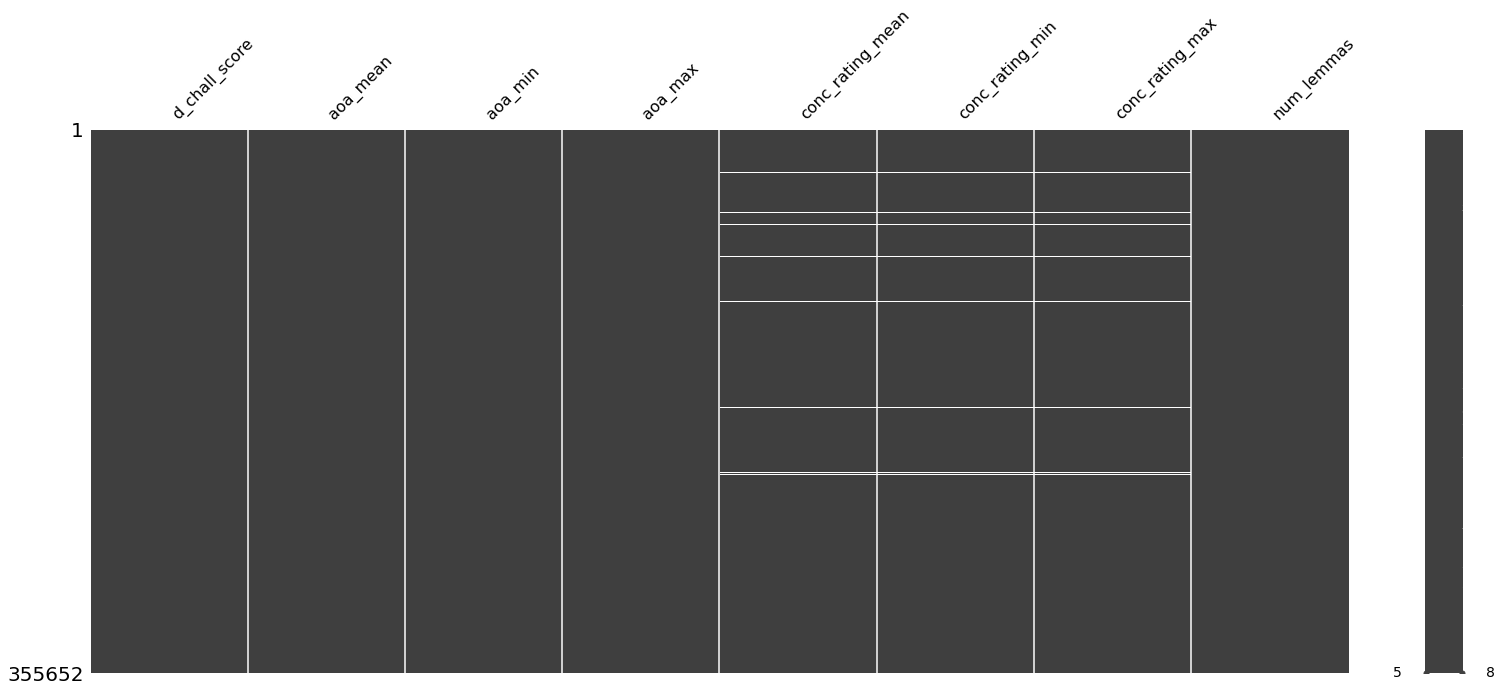

In [121]:
mads_features_raw = new_df.iloc[X_train_indexes,2:10]
msno.matrix(mads_features_raw)
mads_features_raw.fillna(0,inplace=True)

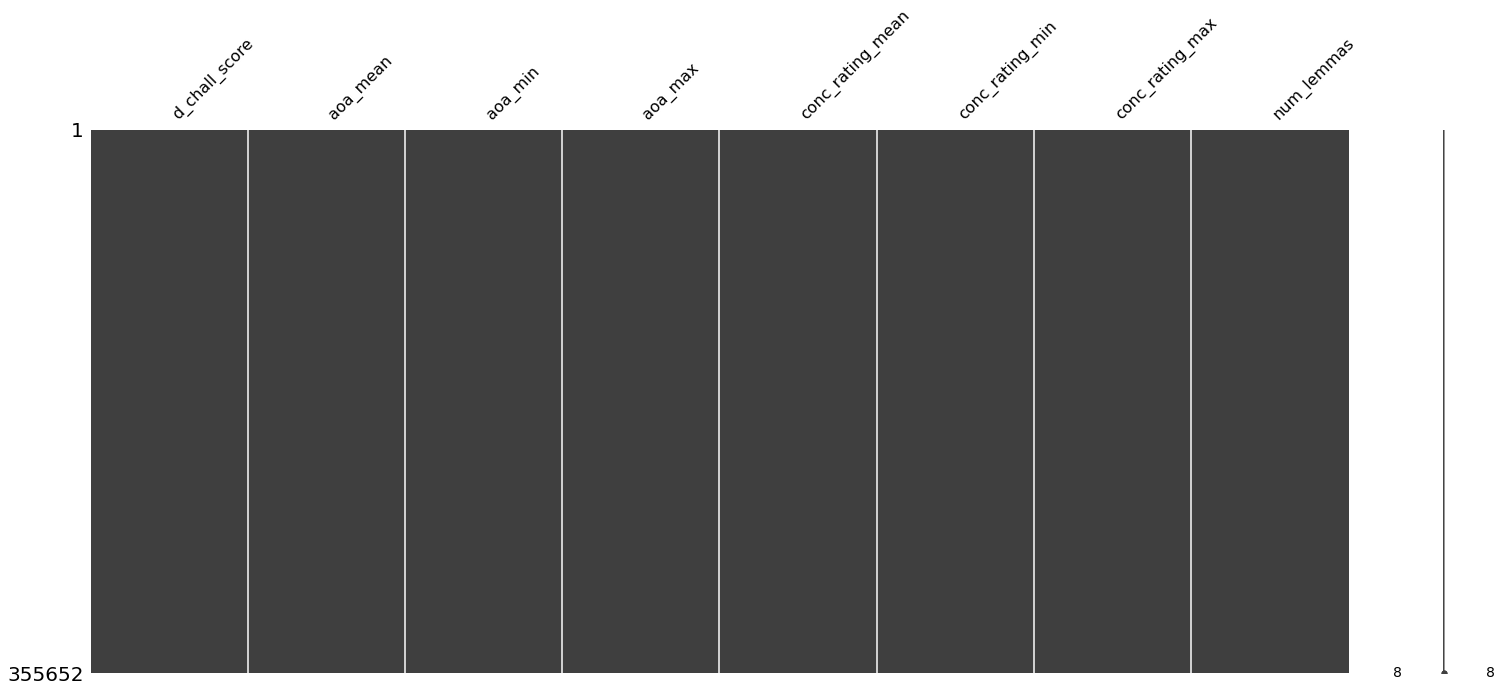

In [122]:
msno.matrix(mads_features_raw)

In [123]:
X_train_emb_mads = np.hstack((X_train_emb_mm,
                              mads_features_raw))

In [124]:
param_grid = {'alpha': [0.001,0.01, 0.1,1,2,3,4,5,6,7,8,9,10,50,100]}
grid_mnb_embmads_rmse = GridSearchCV(MultinomialNB(), param_grid=param_grid, scoring='neg_root_mean_squared_error')
grid_mnb_embmads_rmse.fit(X_train_emb_mads,y_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                   10, 50, 100]},
             scoring='neg_root_mean_squared_error')

In [125]:
grid_mnb_embmads_rmse.best_params_

{'alpha': 50}

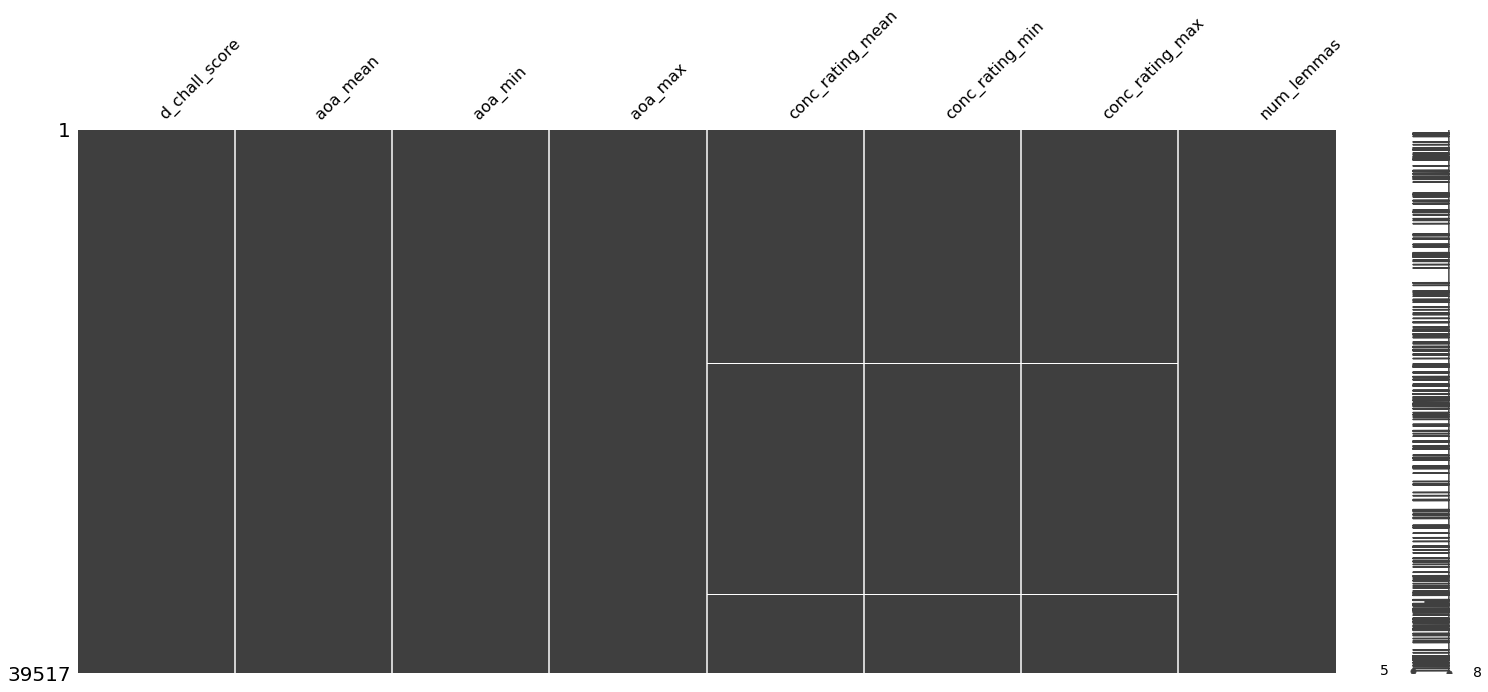

In [127]:
X_test_mads_features = new_df.iloc[X_test_indexes,2:10]
msno.matrix(X_test_mads_features)

In [131]:
# Confirm the number of nan values based on the conc_rating_mean and fill with 0 
X_test_mads_features[X_test_mads_features['conc_rating_mean'].isna()==True]
X_test_mads_features.fillna(0,inplace=True)

In [133]:
X_test_emb_mads = np.hstack((X_test_emb_mm,
                     X_test_mads_features))


mnb = MultinomialNB(alpha=50).fit(X_train_emb_mads, y_train)
model_name = 'embedding NB alpha 50'
compute_metrics(mnb,model_name,X_test_emb_mads, y_test)